# Introduction

Lending Club offers: 
 - **Personal Loans** up tp 40 000 $, which allows you to borrow money from a lender for almost any purpose, typically with a fixed term, a fixed interest rate, and a regular monthly payment schedule. Collateral is usually not required and personal loans typically have lower interest rates than most credit cards.
 - **Business Loans** with lot's of opportunities for varies types of businesses; from small business loans up to 400 000 $ to even 10 million loans for large businesses - equipment financing.
 - **Auto Loan Refinancing**;
 - **Patient Solutions** - loans for medical care. 
 
 More about Lending club [here](https://www.lendingclub.com/).

 
 In this EDA we have data about rejected and accepted loans in Lending Club from 2007 to 2018, almost 30 million observations. I will try to find some patterns, which could indicate first of all:
 1. What are the most important features when deciding to approve or to reject a loan for the applicant;
 2. When it is decided to approve the loan, what features could impact the decision on the loan's: grade, sub_garde and the interest rate.

# 1. Data set up

In [ ]:
from helpers import helpers as h
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats.distributions as dist
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from math import ceil
from pywaffle import Waffle
from IPython.display import Image
from warnings import filterwarnings
filterwarnings(action="ignore")
%matplotlib inline   
%load_ext blackcellmagic

In [7]:
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 100) 
sns.set_theme(style="darkgrid")

In [8]:
df_accepted = pd.read_csv("lending-club\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv")

In [9]:
df_accepted.shape

(2260701, 151)

In [2]:
# All column names from the df_accepted are described in this dictionary and can be checked. 
# Also I matched the titles of the rejected loan data with these too.
df_dictionary = pd.read_excel("lending-club\Data_Dictionary.xlsx")

In [4]:
df_dictionary.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [5]:
df_dictionary[df_dictionary["LoanStatNew"] == "pct_tl_nvr_dlq"].values.tolist()

[['pct_tl_nvr_dlq', 'Percent of trades never delinquent']]

In [6]:
df_rejected = pd.read_csv("lending-club\\rejected_2007_to_2018q4.csv\\rejected_2007_to_2018Q4.csv")

In [7]:
df_rejected.shape

(27648741, 9)

As we have a very large data sets and my machine hasn't got so much memory and computing power to deal with such amount of data, I will try to reduce the number of observations/or even columns, by dealing first with missing values. The proportion of observations right now is: 1 observation from accepted to 12 observations from rejected.

In [8]:
df_rejected.shape[0]/df_accepted.shape[0]

12.230162679629018

* So before cleaning the data (deleting NaN values and etc.) I want to show you the difference in percentage of rejected and accepted loans in the Lending Club in the period from the year 2007 to 2018.

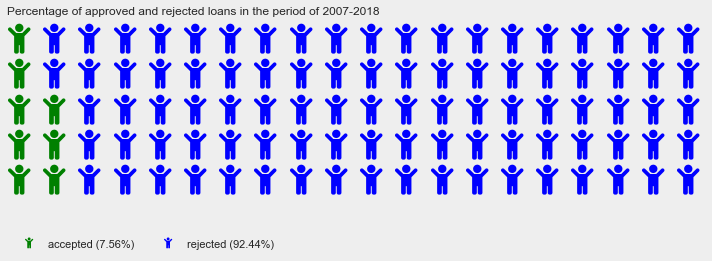

In [10]:
percentage_loans = pd.DataFrame(
    [
        (df_accepted.shape[0] / (df_accepted.shape[0] + df_rejected.shape[0])) * 100,
        (df_rejected.shape[0] / (df_accepted.shape[0] + df_rejected.shape[0])) * 100,
    ],
    index=["accepted", "rejected"],
    columns=["percentage"],
)
h.plot_total_percentage_of_loans(
    percentage_loans,
    "percentage",
    "Percentage of approved and rejected loans in the period of 2007-2018",
)

# 2. Data cleaning

## 2.1. Accepted loans

In [8]:
df_accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,

In [16]:
df_accepted.id.duplicated().sum()

0

* As we checked the "id" column, which represents the unique ID for the loan, there are no duplicated values to remove.

All columns, which have more than 50 percent of NaN values.

In [17]:
df_nans = df_accepted.isna().sum().sort_values(ascending=False)
df_nans[df_nans.values > 1130350]

member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_end_date                             2249784
hardship_start_date                           2249784
hardship_type                                 2249784
hardship_reason                               2249784
hardship_status                               2249784
deferral_term                                 2249784
hardship_last_payment_amount                  2249784
hardship_payoff_balance_amount                2249784
hardship_loan_status                          2249784
hardship_dpd                                  2249784
hardship_length                               2249784
payment_plan_start_date                       2249784
hardship_amount                               2249784
settlement_term                               2226455
debt_settlement_flag_date                     2226455
settlement_status                             2226455
settlement_date             

I decided to drop all columns, which has more than 50 percent of Nan values, first of all because it's obvious that this data is harder to gather (so it will be a challenge in the future too), secondly it is impossible and useless to fill with some kind of values half and even more of the whole data set. Most of the last columns (under 2 million missing values) are month since some kind of the event, most of those events are recorded not once in the dataset. Also non of these columns are in the rejected loans data set.

In [18]:
# extreme outliers
Q1 = df_accepted.quantile(0.1)
Q3 = df_accepted.quantile(0.9)
IQR = Q3 - Q1
((df_accepted < (Q1 - 1.5 * IQR)) | (df_accepted > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False).head(20)

recoveries                    185432
collection_recovery_fee       177013
tot_coll_amt                  139911
num_tl_90g_dpd_24m            117332
total_rec_late_fee             87155
tax_liens                      64630
delinq_2yrs                    58889
collections_12_mths_ex_med     37438
last_fico_range_low            37326
revol_bal                      33950
mo_sin_rcnt_rev_tl_op          33643
num_accts_ever_120_pd          32592
mths_since_rcnt_il             32076
bc_open_to_buy                 28743
mo_sin_rcnt_tl                 28679
mths_since_recent_bc           26654
total_rev_hi_lim               23907
total_cu_tl                    23012
total_bal_ex_mort              22716
annual_inc                     22354
dtype: int64

As we have a big data set, let's remove all extreme outliers too.

* Cleaning

* Deleting Nan columns, removing extreme outlier, inserting new columns: status => 1 (as accepted loan), fico range => mean of columns fico_range_low	fico_range_high and status; new columns of the year and month (extracted from the "issue_d"), removing columns with data that is mostly gathered after the loan was accepted.

In [25]:
cleaned_accepted_df = (
    df_accepted.pipe(h.copy_df)
    .pipe(h.drop_missing)
    .pipe(h.remove_extreme_outlier)
    .pipe(
        h.drop_nan_rows_from_certain_cols,
        ["grade", "sub_grade", "int_rate", "dti", "emp_length"],
    )
    .pipe(h.insert_status, 1)
    .pipe(
        h.insert_mean_of_two_columns, 
        "fico_range_low", 
        "fico_range_high", 
        "fico_score")
    .pipe(
        h.insert_mean_of_two_columns,
        "last_fico_range_low",
        "last_fico_range_high",
        "last_fico_score",
    )
    .pipe(h.year_month, "issue_d")
    .pipe(h.month_to_int, "month")
    .pipe(
        h.drop_columns,
        [
            "id",
            "installment",
            "fico_range_low",
            "fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "issue_d",
            "url",
            "zip_code",
            "policy_code",
            "verification_status",
            "loan_status",
            "pymnt_plan",
            "revol_bal",
            "revol_util",
            "initial_list_status",
            "out_prncp",
            "total_pymnt",
            "total_pymnt_inv",
            "total_rec_prncp",
            "out_prncp_inv",
            "total_rec_int",
            "total_rec_late_fee",
            "recoveries",
            "collection_recovery_fee",
            "last_pymnt_d",
            "last_pymnt_amnt",
            "last_credit_pull_d",
            "collections_12_mths_ex_med",
            "acc_now_delinq",
            "tot_coll_amt",
            "tot_cur_bal",
            "open_acc_6m",
            "open_act_il",
            "open_il_12m",
            "open_il_24m",
            "mths_since_rcnt_il",
            "total_bal_il",
            "il_util",
            "open_rv_12m",
            "open_rv_24m",
            "max_bal_bc",
            "all_util",
            "total_rev_hi_lim",
            "inq_fi",
            "title",
            "total_cu_tl",
            "bc_open_to_buy",
            "bc_util",
            "chargeoff_within_12_mths",
            "delinq_amnt",
            "mths_since_recent_inq",
            "num_accts_ever_120_pd",
            "num_rev_tl_bal_gt_0",
            "num_tl_120dpd_2m",
            "num_tl_30dpd",
            "num_tl_90g_dpd_24m",
            "num_tl_op_past_12m",
            "percent_bc_gt_75",
            "tax_liens",
            "tot_hi_cred_lim",
            "total_bal_ex_mort",
            "total_bc_limit",
            "total_il_high_credit_limit",
            "disbursement_method",
            "debt_settlement_flag",
        ],
    )
    .pipe(h.certain_column_lower, "emp_title")
    .pipe(h.certain_column_lower, "home_ownership")
)

In [26]:
# dti score.
cleaned_accepted_df = cleaned_accepted_df[~(cleaned_accepted_df["dti"] < 0)]

## 2.2. Rejected loans

In [12]:
df_rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.00,2007-05-26,Wedding Covered but No Honeymoon,693.00,10%,481xx,NM,4 years,0.00
1,1000.00,2007-05-26,Consolidating Debt,703.00,10%,010xx,MA,< 1 year,0.00
2,11000.00,2007-05-27,Want to consolidate my debt,715.00,10%,212xx,MD,1 year,0.00
3,6000.00,2007-05-27,waksman,698.00,38.64%,017xx,MA,< 1 year,0.00
4,1500.00,2007-05-27,mdrigo,509.00,9.43%,209xx,MD,< 1 year,0.00


In [13]:
df_rejected.shape

(27648741, 9)

In [23]:
df_rejected.isna().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

According to the information of the missing data, there is no possibility to fill in Risk score as it is one of the main possible predictors for the loan rejection. The same with employment length, that is very unique for every applicant, so I decided to drop all NaN values, as we have more than 27 million observations and I'm not able to use all given data according to the computing power of my computer.

In [14]:
names = {"Amount Requested": "loan_amnt", "Loan Title": "purpose", "Risk_Score":"fico_score", "Debt-To-Income Ratio":"dti", "State":"addr_state", "Employment Length":"emp_length"}
cleaned_df_rejected = (
    df_rejected.pipe(h.copy_df)
    .pipe(h.drop_all_nan_rows)
    .pipe(h.remove_extreme_outlier)
    .pipe(h.extract_year_month, "Application Date")
    .pipe(h.drop_columns, ["Application Date", "Zip Code", "Policy Code"])
    .pipe(h.purpose_of_the_loan, "Loan Title")
    .pipe(h.insert_status, 0)
    .pipe(h.rename_columns, names)
    )

In [15]:
# Fico score
cleaned_df_rejected = cleaned_df_rejected[~(cleaned_df_rejected["fico_score"] > 850)]

In [16]:
# Additional cleaning of "dti".
cleaned_df_rejected["dti"] = cleaned_df_rejected["dti"].str.rstrip('%')
cleaned_df_rejected["dti"] = pd.to_numeric(cleaned_df_rejected["dti"])
cleaned_df_rejected.loc[(cleaned_df_rejected["dti"] < 0) | (cleaned_df_rejected["dti"] > 100), "dti"] = 100

# 3. Main data analysis
## 3.1. Target - decision: accept/reject the loan

I'll take a subset of accepted loan with the same columns as in the rejected loans, for further exploring. 

In [17]:
accepted_subset = cleaned_accepted_df[cleaned_df_rejected.columns.to_list()]

### **3.1.1 Loan amount**

The listed amount of the loan applied for by the borrower.

In [22]:
final_loans = pd.concat([accepted_subset, cleaned_df_rejected], ignore_index=True)
final_loans.shape

(10203576, 9)

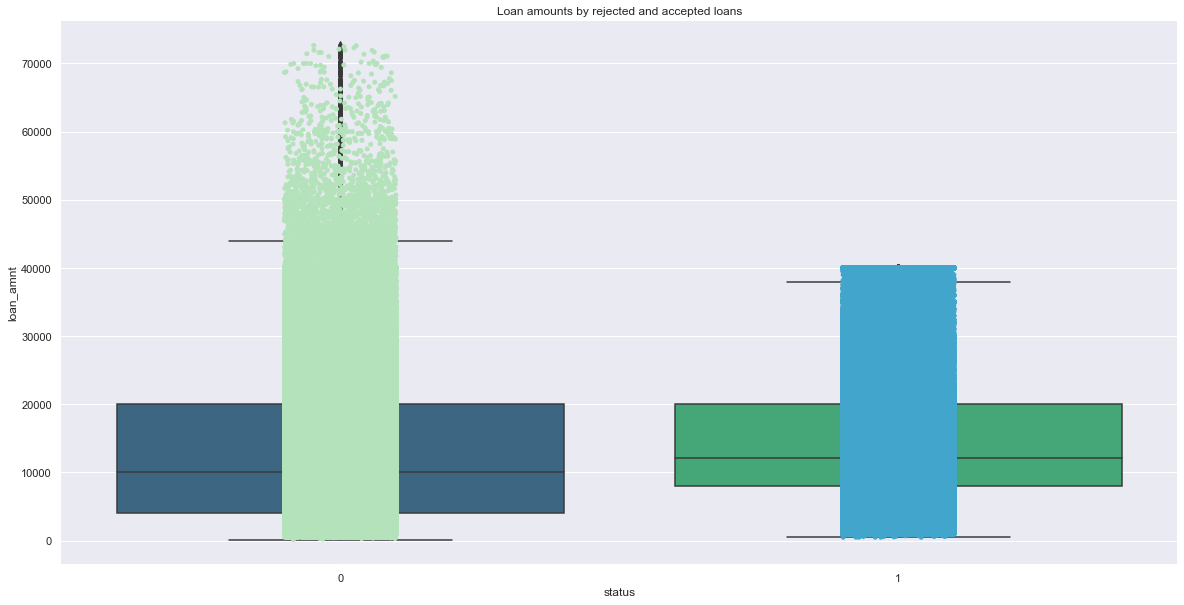

In [23]:
h.plot_box_stripplot(final_loans, "status",  "loan_amnt", "Loan amounts by rejected and accepted loans")

Even though I have dropped all the extreme outliers in both data sets, we may obviously see that people, whose applications for loans were rejected, were requesting larger sums: up to 70 000 dollars. According to the information, given in the LendingClub web page(https://www.lendingclub.com/), personal loans are only  up to 40 000 dollars. Of course, business loans can be larger. So we'll compare the purpose of the applicants and the amount of the application.

* Distributions of both.

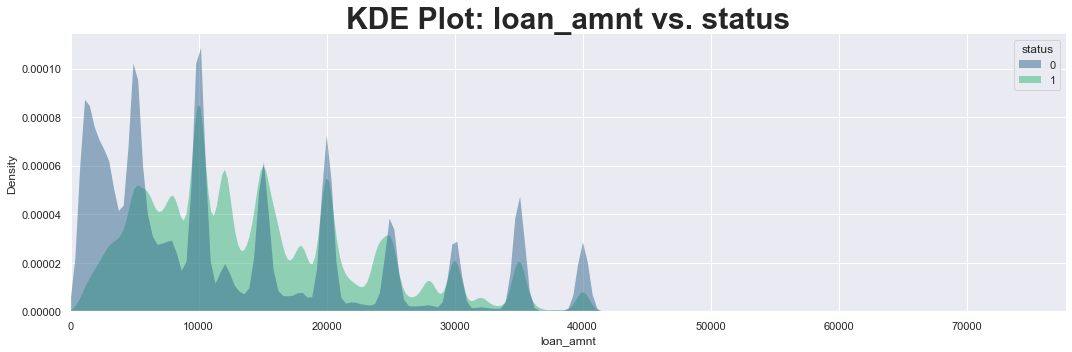

In [44]:
h.plot_kde(final_loans, "loan_amnt", "status")

Conclusions:
1. rejected loans: 
* more often smaller amounts were asked: starting from 150 to 5000 $;
* upper bound of loan amount is higher, reaches even 70 000 $, when LendingClub offers personal loans only up to 40 000, some of the rejected applications with large loan amounts must be business loans;
* more often people asked rounded sums 10 000, 15 000, 20 000 $ and etc.
* the mean of the asked loan amount is lower and reaches 12672.95$, but the standard deviation is higher - 10873.32 $.

2. accepted loans:
* starts from 500$, end at 40 000$  - all in the range of personal loans;
* more often not rounded sums were asked, seems that people better knew how much and for what certain purpose they are asking the loan;
* mostly were asked sums from 5000 to 25 000 $.
* mean of the asked loan amounts is actually higher and reaches: 14530.83$, but standard deviation is lower - 8647.43$.

Let's see is the difference in the means of two populations statistically significant?


* **Inferential statistical analysis:**

**Research question**
When considering people, whose loan applications were approved or rejected, is the difference in means of asked loan amount in these two groups statistically significant? (hypothesis test comparing means of two independent populations)

**Population**: all loan applications.

**Population subgroups**: 
1. accepted loan applications;

2. rejected loan applications.

**Parameter of Interest**: difference in population subgroups mean applied loan amount.

**Power of the test** ($1 - \beta$) - 0.8 as a convention.

**Significance level**: 0.05

**Null Hypothesis:** H(O): $\mu$ (1) -$\mu$ (2) = 0

**Alternative Hypothesis:** $\mu$ (1) - $\mu$ (2) > 0

This will be a *one tail* testing.


In [23]:
inferent_statist_means = h.DiffMeans(accepted_subset, cleaned_df_rejected, "loan_amnt", "loan_amnt")

In [24]:
inferent_statist_means.make_table()

,n,mean,std
accepted,1337923,14530.82,8647.44
rejected,8865653,12655.51,10860.39


**Assumptions**:
1. I assume that those are simple random samples. Samples are independent one from each other.
2. The distributions of loan amount of both subpopulations doesn't seem normal, both are skewed to the right, but there are more than 10 million observations per both data sets, so accounting on Central limit theorem, I still proceed the t-testing.
3. I assume that the standard deviations of these two populations are not similar, it differ up to 2000$. That's why I use the unpooled approach.

The difference of these two means is:

In [25]:
inferent_statist_means.diff_of_means()

1875.310266747676

* Required sample size to avoid p-hacking in each of the populations:
The same with this [calculator](https://www.stat.ubc.ca/~rollin/stats/ssize/n2)

In [26]:
inferent_statist_means.sample_size_needed()

Required sample size:339


We have a lot bigger sample sizes, so p-hacking should be avoid.

In [27]:
inferent_statist_means.t_statistics()

T-statistic: 225.44214874966585, p-value: 0.0


To conclude, the t - statistics:  225, so the difference between sample means of applied loan amount, are above the hypothesized 0 value by more than 225 estimated standard errors, thats a lot. The p-value is actually equal to zero and is definitely smaller than the alpha of 0.05. So, there's enough evidence to reject the NULL hypothesis. The difference of the means of applied loan amounts is significantly higher in the group, where loans were approved. So from data we have, can be concluded that, people with approved loans on average asked for bigger loans.

* Confidence interval of the difference between two means of loan amount.
1. Confidence level of 95%.
2. Significant level alpha = 0.05
3. Unpooled approach.

In [28]:
inferent_statist_means.conf_interval_of_difference()

(1859.006559605887, 1891.6139738894612)


The difference of two means in our case was - 1857.88$, the reasonable values for ths difference are from 1841.57 to 1874.18 $ and 0 is by far not in this interval, so the conclusion to reject the null hypothesis was correct.

### **3.1.2. Purpose**

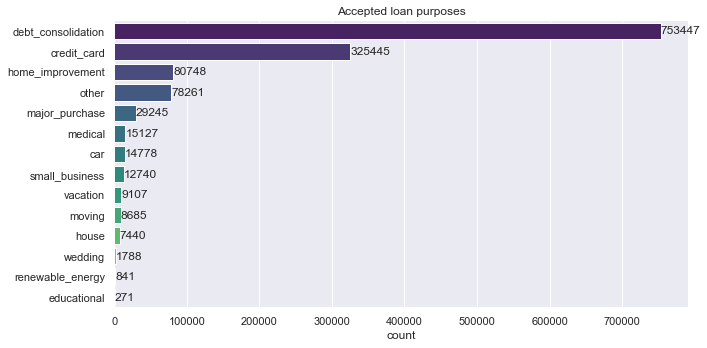

In [29]:
h.plot_countplot_vertical(accepted_subset, "purpose", None, "Accepted loan purposes")

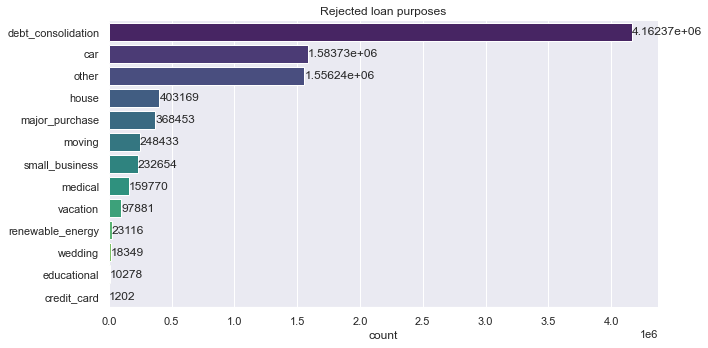

In [30]:
h.plot_countplot_vertical(cleaned_df_rejected, "purpose", None, "Rejected loan purposes")

Conclusion:
1. Accepted loan:
* mostly loans were given for these purposes: debt_consolidation, credit_card, home_improvement and other reason.

2. Rejected loans:
* mostly loans were asked for the purposes of: debt_consolidation, car (possibly auto loan refinancing, financing for the new car and etc.) and other reasons. Actually purposes related to credit_card here is in the last place.
* there is a large number of "other" reasons for the loan, which possibly aren't so important or even cannot be financed.

### **3.1.3. Fico score**

Fico score, or credit score in other words, used in US very widely. FICO weighs each category differently for each individual. However, in general, payment history is 35% of the score, accounts owed is 30%, length of credit history is 15%, new credit is 10%, and credit mix is 10%. According to recourses [here](https://www.investopedia.com/terms/f/ficoscore.asp) fico credit score ranges between 300 and 850, so values lower than 300 and higher than 850, could be considered as bad data. On the other hand people may not have fico score at all, for example if they do not have credit card.

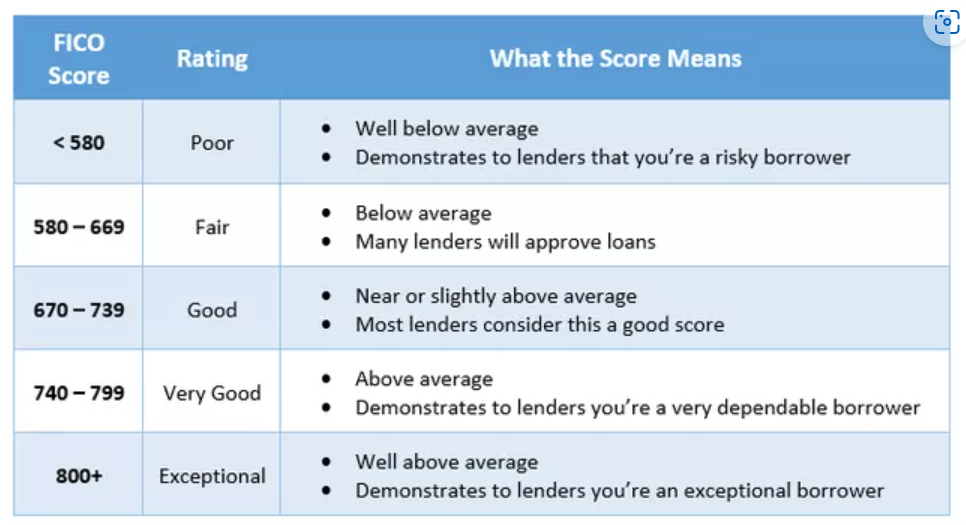

In [44]:
# Image taken from: https://www.investopedia.com/terms/f/ficoscore.asp.
Image(filename="png\\fico_score.png")

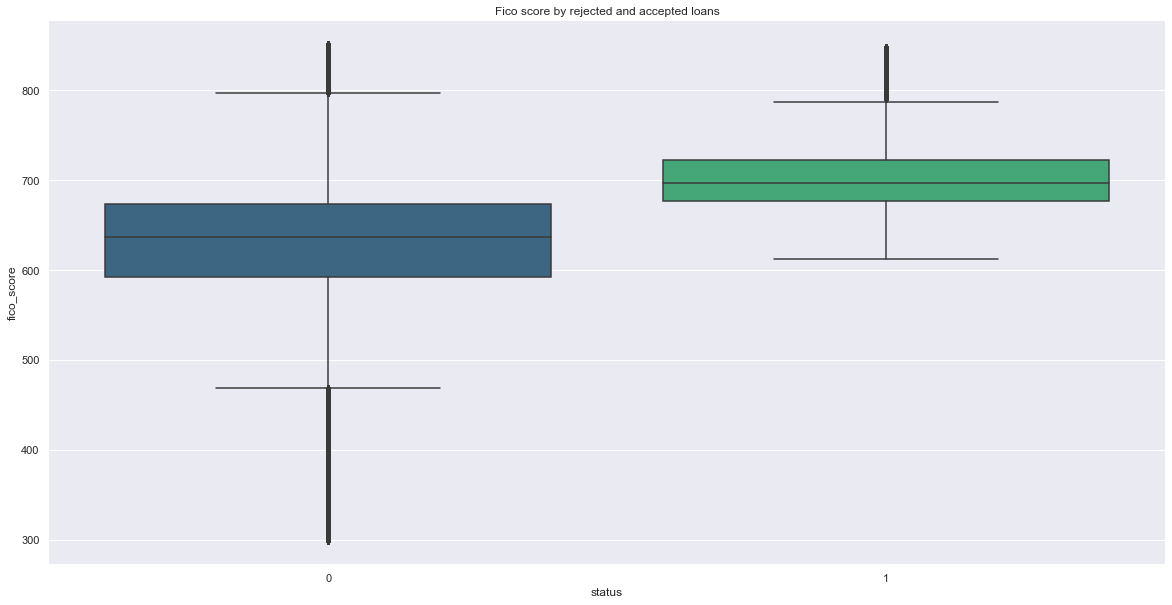

In [34]:
h.plot_boxplot(final_loans, "status",  "fico_score", "Fico score by rejected and accepted loans")

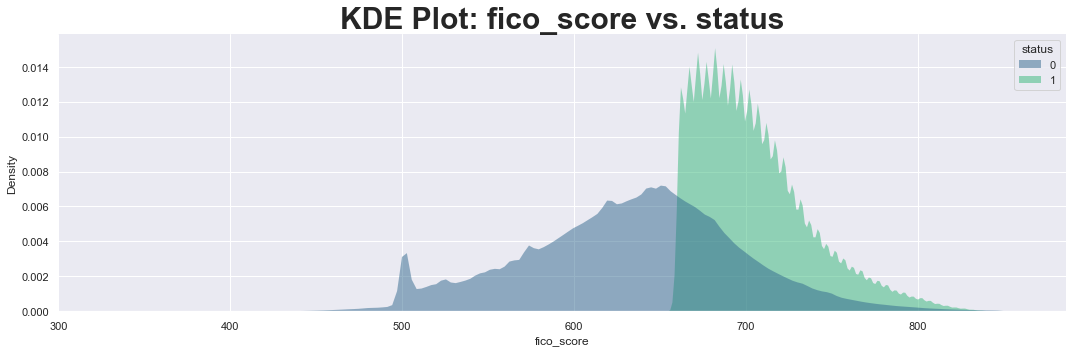

In [62]:
h.plot_kde(final_loans, "fico_score", "status")

* A really clear pattern is observed, to get a loan for sure you need to have Fico score from aprox. 660 and above. 
* The mean of the Fico score in the accepted loans data set ir obviously higher, so let's see if the difference is statistically significant.
* Standard deviation of Fico score in rejected loans data set is actually double, compared to the Fico score std in the accepted loan group. So the variance of Fico score in the rejected loans group is definitely higher.

* **Inferential statistical analysis:**

**Research question**
When considering people, whose loan applications were approved or rejected, is the difference in means of Fico score in these two groups statistically significant? (hypothesis test comparing means of two independent populations)

**Population**: all loan applications.

**Population subgroups**: 
1. accepted loan applications;

2. rejected loan applications.

**Parameter of Interest**: difference in population subgroups mean of fico score.

**Power of the test** ($1 - \beta$) - 0.8 as a convention.

**Significance level**: 0.05

**Null Hypothesis:** H(O): $\mu$ (1) -$\mu$ (2) = 0

**Alternative Hypothesis:** $\mu$ (1) - $\mu$ (2) > 0

This will be a *one tail* testing.


In [35]:
inferent_statist_means_fico = h.DiffMeans(accepted_subset, cleaned_df_rejected, "fico_score", "fico_score")

In [36]:
inferent_statist_means_fico.make_table()

,n,mean,std
accepted,1337923,704.48,33.16
rejected,8865653,632.58,64.23


**Assumptions**:
1. I assume that those are simple random samples. Samples are independent one from each other.
2. The distributions of loan amount of both subpopulations doesn't seem normal, both are skewed to the right, but there are more than 10 million observations per both data sets, so accounting on Central limit theorem, I still proceed the t-testing.
3. I assume that the standard deviations of these two populations are not similar, according to very large total numbers of annual income. That's why I use the unpooled approach.

The difference of these two means is:

In [37]:
inferent_statist_means_fico.diff_of_means()

71.89770223057008

* Required sample size to avoid p-hacking in each of the populations:
The same with this [calculator](https://www.stat.ubc.ca/~rollin/stats/ssize/n2)

In [38]:
inferent_statist_means_fico.sample_size_needed()

Required sample size:7


We have a lot bigger sample sizes, so p-hacking should be avoid.

In [39]:
inferent_statist_means_fico.t_statistics()

T-statistic: 2004.0917131264348, p-value: 0.0


To conclude, the t - statistics in this case is enormous - 2004, so the difference between sample means of fico range, are above the hypothesized 0 value by more than 2004 estimated standard errors. The p-value is actually equal to zero. So, there's enough evidence to reject the NULL hypothesis. The difference of the means of fico score is significantly higher in the group, where loans were approved.

* Confidence interval of the difference between two means of loan amount.
1. Confidence level of 95%.
2. Significant level alpha = 0.05
3. Unpooled approach.

In [40]:
inferent_statist_means_fico.conf_interval_of_difference()

(71.8273876035045, 71.96801685763565)


The difference of two means of the fico score in our case was - 71,89, the reasonable values for ths difference are from 71.82 to 71.96 and 0 is by far not in this interval, so the conclusion to reject the null hypothesis was correct.

### **3.1.4. Debt to income ratio**

In [30]:
df_dictionary[df_dictionary["LoanStatNew"] == "dti"].values.tolist()

[['dti',
  'A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.']]

Debt to income ratio - the percentage of your gross monthly income that goes to paying your monthly debt payments and is used by lenders to determine your borrowing risk. A low debt-to-income (DTI) ratio demonstrates a good balance between debt and income. Conversely, a high DTI ratio can signal that an individual has too much debt for the amount of income earned each month. Typically, borrowers with low debt-to-income ratios are likely to manage their monthly debt payments effectively. Ideally, lenders prefer a debt-to-income ratio lower than 36%, with no more than 28% of that debt going towards servicing a mortgage or rent payment  [more here](https://www.investopedia.com/terms/d/dti.asp). 

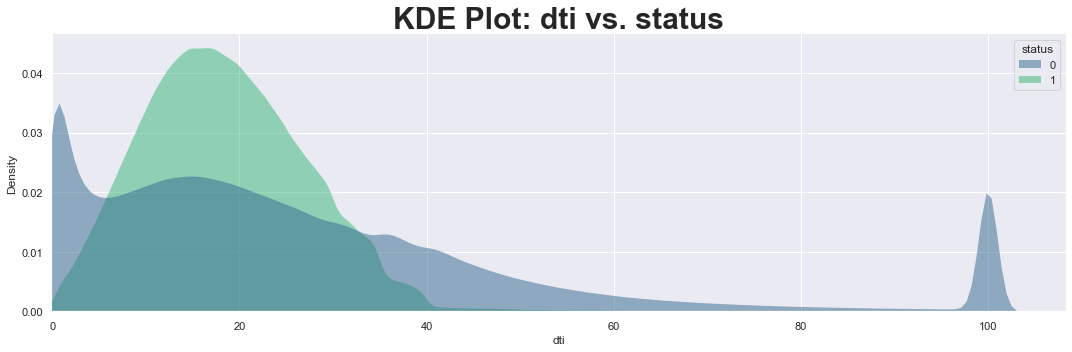

In [67]:
h.plot_kde(final_loans, "dti", "status")

First of all in the cleaning part I changed all values, that exceeded 100 to 100, as by counting it is possible to have dti of even thousands, but to the modeling that would make more harm in my opinion, so I chose the highest possible value of 100 percent.

Conclusions:
* Obviously, to get a loan with Debt to income ratio exceeding 40 percent is impossible. 
* Most of the loans were given to people with Debt to income ratio between 15-25 percent. 
* Also we may see, that people with Debt to income ratio equal to 0 are also mostly are in the rejected group, so it seems that ratio of 0 is also some kind of suspicious.
* Distribution of dti in the accepted group is quite normal. In the rejected group - skewed to the right, so some log transformations may be needed.
* Standard deviation of the dti in the rejected group is almost three times higher than in the accepted loan group. So values obviously are mors spread away in the rejected group.

### **3.1.5. Address State**

In [43]:
df_dictionary[df_dictionary["LoanStatNew"] == "addr_state"].values.tolist()

[['addr_state', 'The state provided by the borrower in the loan application']]

Let's see which states lead and which ar in tail by the number of approved loans.

In [44]:
states_accepted = pd.DataFrame(
    {"total_loans_accepted": accepted_subset["addr_state"].value_counts()}
).reset_index()
state_rejected = pd.DataFrame(
    {"total_loans_rejected": cleaned_df_rejected["addr_state"].value_counts()}
).reset_index()
states = pd.merge(states_accepted, state_rejected, on="index")
states["total_applied"] = (
    states["total_loans_accepted"] + states["total_loans_rejected"]
)
states["percentage_accepted"] = (
    states["total_loans_accepted"] / states["total_applied"] * 100
)
states["percentage_rejected"] = (
    states["total_loans_rejected"] / states["total_applied"] * 100
)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))
states["state_name"] = states["index"].map(abbrev_to_us_state)
states["percentage_accepted"] = states["percentage_accepted"].round(2)
states["percentage_rejected"] = states["percentage_rejected"].round(2)

In [45]:
states[["state_name", "total_applied", "percentage_accepted"]].sort_values(
    ascending=False, by="percentage_accepted"
).head(3)

,state_name,total_applied,percentage_accepted
17,Minnesota,139171,18.20
14,Colorado,178280,17.06
48,North Dakota,14203,16.71


In [46]:
states[["state_name", "total_applied", "percentage_accepted"]].sort_values(
    ascending=False, by="percentage_accepted"
).tail(3)

,state_name,total_applied,percentage_accepted
25,Alabama,174043,8.97
34,Mississippi,85635,8.10
50,Iowa,377,2.65


In [47]:
for col in states.columns:
    states[col] = states[col].astype(str)

states["text"] = states["state_name"] + "<br>" + \
    "Total applied: " + states["total_applied"] + ',' + "accepted % :" + states["percentage_accepted"] + '<br>' + \
    "rejected %" + states["percentage_rejected"]


fig = go.Figure(data=go.Choropleth(
    locations=states["index"],
    z=states["total_applied"].astype(float),
    locationmode="USA-states",
    colorscale="darkmint",
    autocolorscale=False,
    text=states["text"], 
    marker_line_color="white",
    colorbar_title="Loans applied"
))

fig.update_layout(
    title_text="2007-2018 US loan applications/accepted/rejected by State<br>(Hover for breakdown)",
    geo = dict(
        scope="usa",
        projection=go.layout.geo.Projection(type = "albers usa"),
        showlakes=True, # lakes
        lakecolor="rgb(255, 255, 255)"),
)

fig.show()


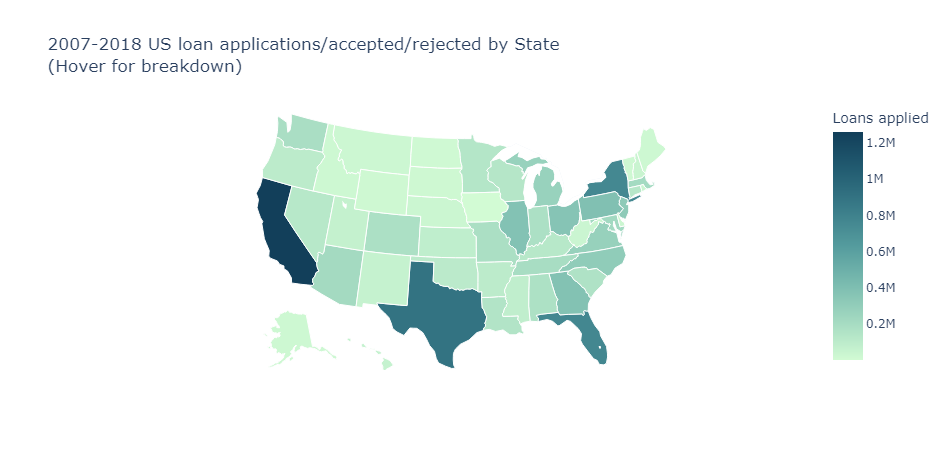

In [73]:
# If plotly doesn't show a chart, here it is.
Image(filename="png\map.png")

Seems that states with larger populations obviously have more loan applications: California, Texas, Florida and new York, but:
* the highest percent of accepted loans are not in the largest states, but in Minnesota, Colorado and North Dakota;
* the lowest percentage of acceptance is in: Alabama, Mississippi, Iowa.

### **3.1.6. Employment length**

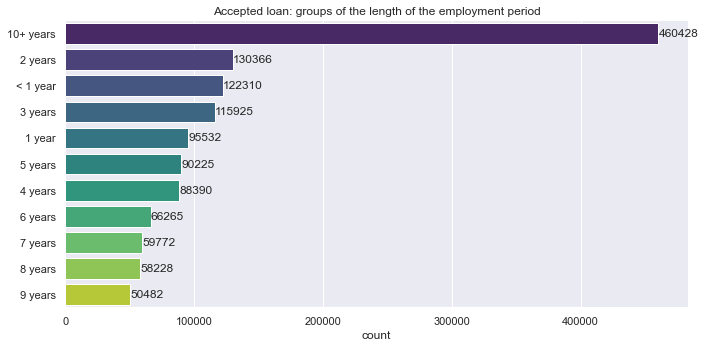

In [48]:
h.plot_countplot_vertical(
    accepted_subset,
    "emp_length",
    None,
    "Accepted loan: groups of the length of the employment period",
)

Most of the loan acceptant's are employed for more than 10 years, but the next two groups are quite surprising. Lending Club approves loans for people with 2 and even less than 1 year of employment quite well too.

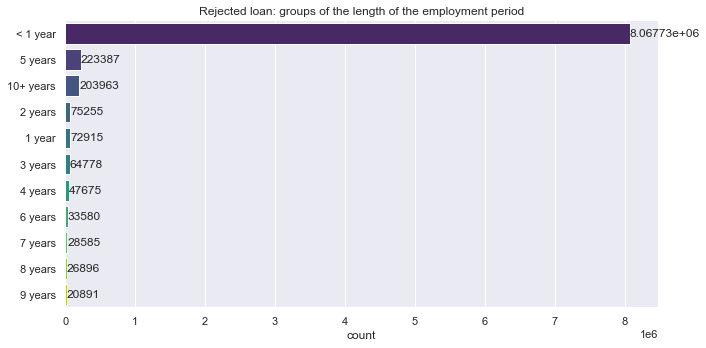

In [49]:
h.plot_countplot_vertical(
    cleaned_df_rejected,
    "emp_length",
    None,
    "Rejected loan: groups of the length of the employment period",
)

And here is the totally opposite situation, where we have, that the wast majority of rejected applicant did not have even one year of employment. So term of employment is actually a quite good predictor.

* Let's see how fico score and dti varies inside these employment groups of accepted loans.

In [50]:
emp_fico_dti_accepted = accepted_subset[["fico_score", "dti", "emp_length"]]

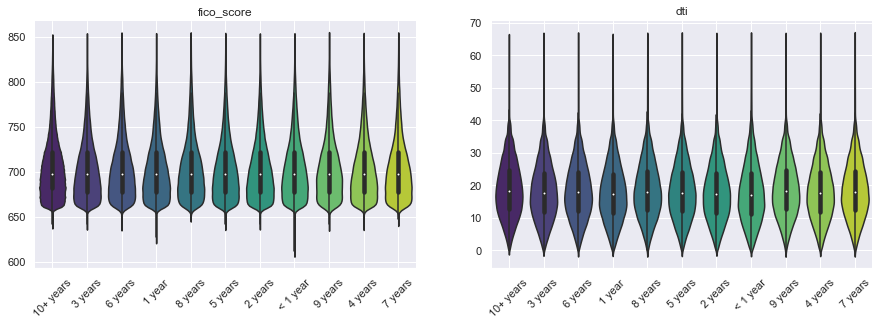

In [51]:
h.multiple_violinplots(emp_fico_dti_accepted, "emp_length")

Actually I cannot see any certain patterns, all distributions look quite similar, so in the accepted loans data, there doesn't seem to be strong relationship between length of employment, fico score and dti ratio.

In [52]:
emp_fico_dti_rejected = cleaned_df_rejected[["fico_score", "dti", "emp_length"]]

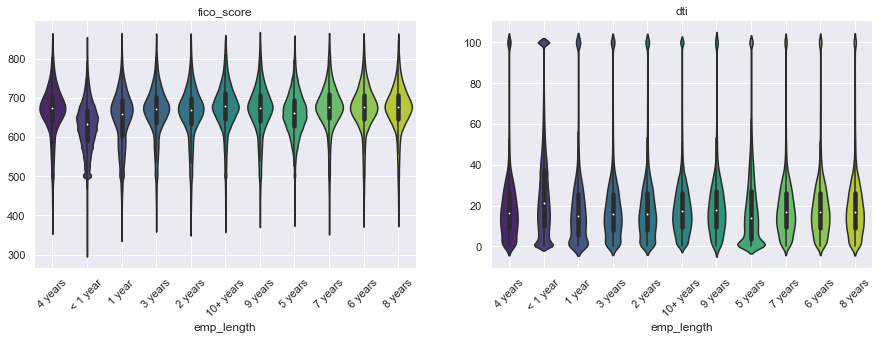

In [91]:
h.multiple_violinplots(emp_fico_dti_rejected, "emp_length")

In the rejected data set we clearly see patterns, that people with less than 1 year of employment experience has lower fico range (mean and absolute minimum) and higher mean of dti (also the upper outliers - 100 percent ratio of dti). So there is a relationship between length of employment and calculated fico score and dti.

### **3.1.7 Year and month of application**

In [53]:
year_df = pd.DataFrame(final_loans.groupby(["status"])["year"].value_counts())
year_df = year_df.rename(columns={"year":"count"}).reset_index().sort_values(ascending=False, by="year")

In [58]:
plot_line_plot_plotly(year_df, "year", "count", "status", "Number of loans accepted/rejected by year")

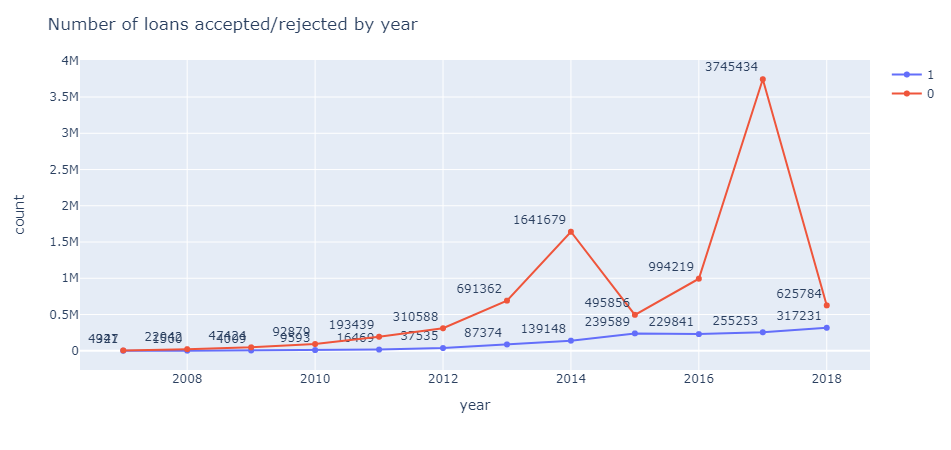

In [247]:
# If plotly doesn't show a chart, here it is.
Image(filename="png\line_plot_year.png")

The number of the accepted loans is increasing steadily year by year and the number of rejected loans differs quite a lot. It may be due to the fact, that I deleted a lot  of data and some years must have had a lot of NaN values (like the year of 2015). But all in all we can see the increase in the number if accepted and rejected loans year by year.

* Let's see are the any special months with the highest or lowest number of accepted/rejected loans.

In [59]:
months = pd.DataFrame(final_loans.groupby(["status"])["month"].value_counts())
months = months.rename(columns={"month":"count"}).reset_index().sort_values(ascending=False, by="month")

In [96]:
h.plot_line_plot_plotly(months, "month", "count", "status", "Number of loans accepted/rejected by months")

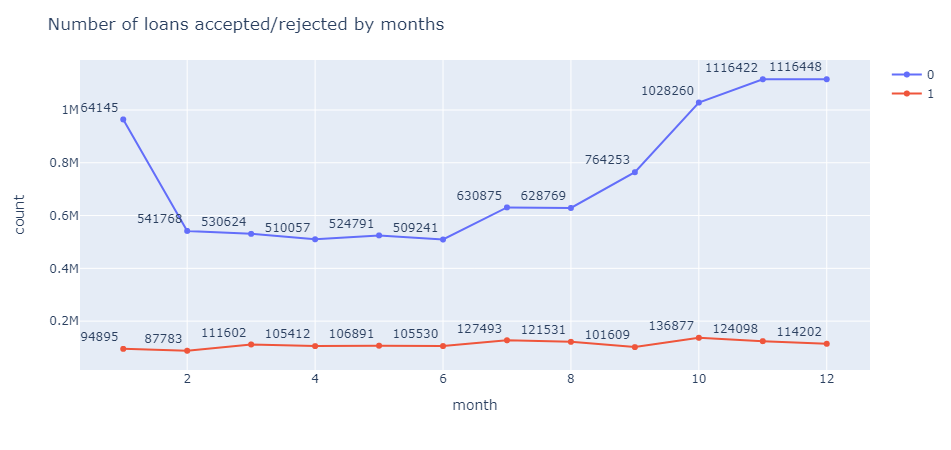

In [248]:
# If plotly doesn't show a chart, here it is.
Image(filename="png\line_plot_month.png")

The number of accepted loans is very stable during every month of the year, there is no major increases or decreases. On the other hand the number of rejected loans by months varies very much. We see that starting from July it starts to increase (probably the number of applies increase too) and reaches the peak in December (that's probably related to the main holidays of the year). Let's see the purpose of the loans in the end of the year.

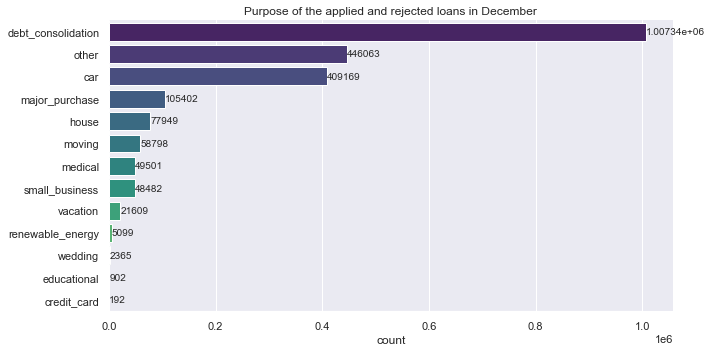

In [60]:
last_months_loans = cleaned_df_rejected[cleaned_df_rejected["month"] > 10][["purpose"]]
h.plot_countplot_vertical(last_months_loans, "purpose", None, "Purpose of the applied and rejected loans in December")

No, the purpose doesn't change, remains the same as in the whole.

## 3.2. Accepted loans


### **3.2.1. Additional analysis of some features**

* Let's see what is the difference between asked loan amounts and funded sums.

In [61]:
different_in_loans = cleaned_accepted_df[["loan_amnt","funded_amnt", "grade"]]
different_in_loans["difference"] = different_in_loans["loan_amnt"] - different_in_loans["funded_amnt"]
got_lower = different_in_loans[different_in_loans["difference"] > 0]

In [62]:
got_lower.difference.describe()

count    1508.00
mean     5637.48
std      3411.09
min        25.00
25%      3025.00
50%      5300.00
75%      7800.00
max     21150.00
Name: difference, dtype: float64

Mostly people, whose application for loan got accepted, got the asked amount of money. There were only 1508 cases, when people got lower amount of asked loan. The differences in asked and funded loan amounts varies from 25$ to 21 150$, the median of funded difference is 5300 $. 

* Let's see what type of applications are major.

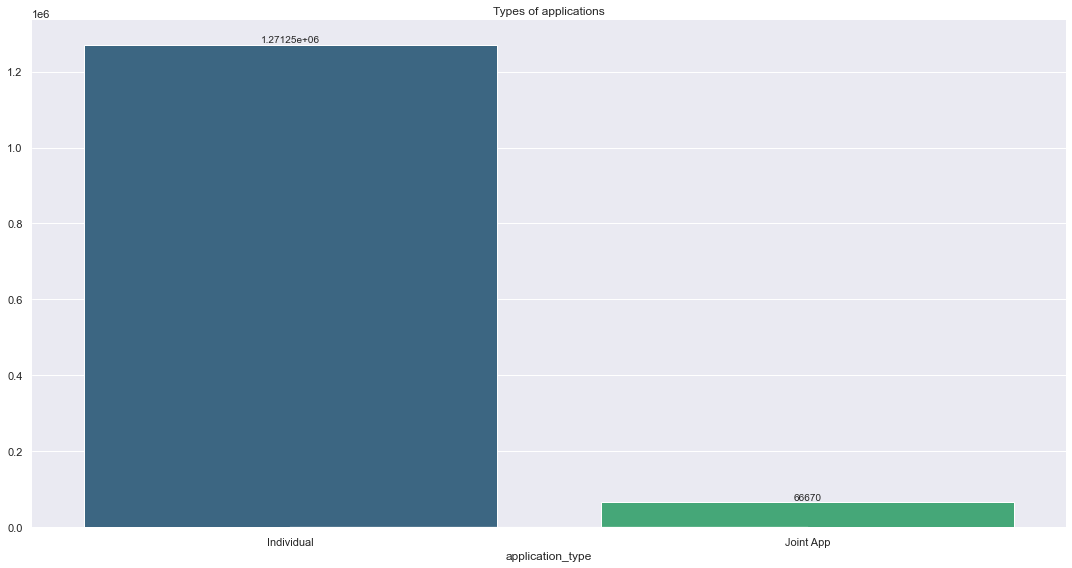

In [63]:
h.plot_countplot_horizontal(cleaned_accepted_df, "application_type", None, "Types of applications")

The major number of loan application are of type - individual, even though joint applications have a higher possibility of approval and higher funded loan amount.

* Home ownership.

In [64]:
percentage = pd.DataFrame(cleaned_accepted_df["home_ownership"].value_counts(normalize=True)*100)
percentage["home_ownership"] = percentage["home_ownership"].round(2)

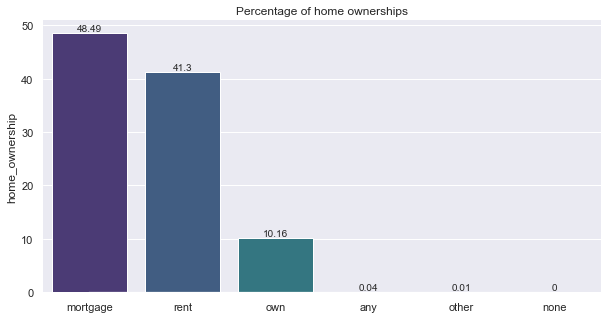

In [65]:
h.plot_barplot(percentage, "home_ownership","Percentage of home ownerships")

Mostly people have a mortgage, rents houses or owns. So other options could be combined into one: other.

In [ ]:
h.change_value(cleaned_accepted_df, "home_ownership", "any", "other")
h.change_value(cleaned_accepted_df, "home_ownership", "none", "other")

* Employment type (title).

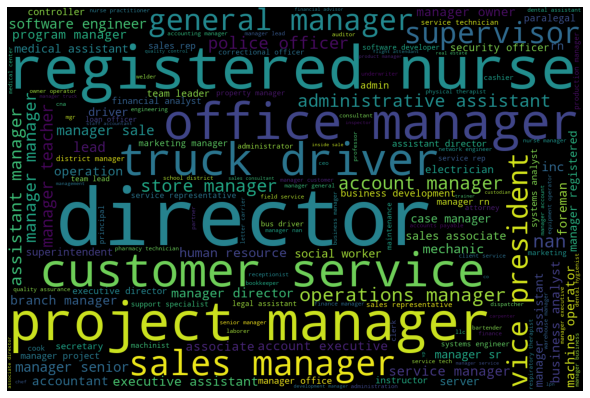

In [134]:
h.plot_world_cloud(cleaned_accepted_df, "emp_title")

So we may see that a lot of different kind of managers, secretaries, teachers, engineer applied for loan. Let's group them into main categories: 

In [ ]:
h.employment_type(cleaned_accepted_df, "emp_title")

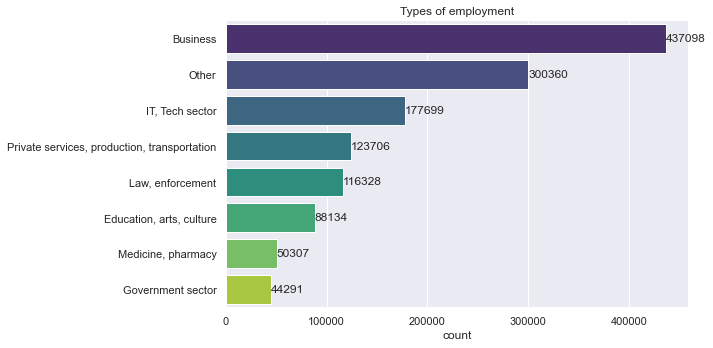

In [14]:
h.plot_countplot_vertical(cleaned_accepted_df, "emp_title", None, "Types of employment")

So mostly people wrote, that they work in business sphere (more administrative functions, like director, manager and so on) and a lot of did not match any selected category and are assigned to others. law and enforcement could be considered like a more risky work sphere, as there were also assigned police officers, army and etc.

* Hardship loans - people reach for them when some kind of disaster occurs in their life. So let's see how many hardship loans were approved in this data set.

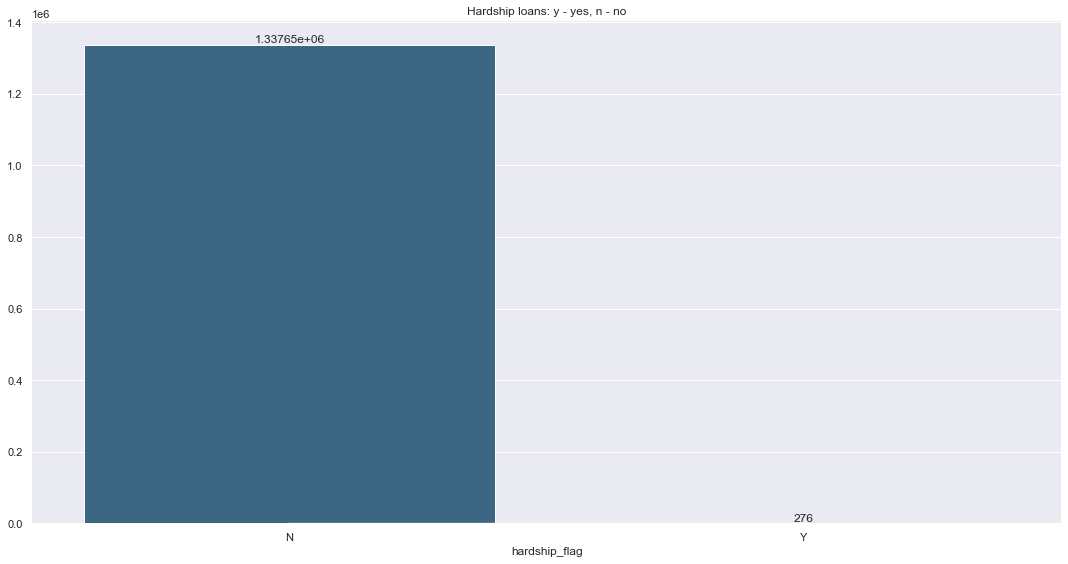

In [15]:
h.plot_countplot_horizontal(cleaned_accepted_df, "hardship_flag", None, "Hardship loans: y - yes, n - no")

So clearly this type of loans is not so popular, o Lending Club is not the first place to go to, when life disasters happen.

### **3.2.2. Target: grade**

Loan grading is the system a bank uses to evaluate the likelihood that borrowers will fail to make their loan payments. Having a loan grading system in place ensures that banks can make good lending decisions. It establishes a cutoff point to help lenders decide how much risk they’re willing to take on, [more about this here](https://www.thebalancemoney.com/what-is-loan-grading-5211003). 
The loan grade is the result of a formula that takes into account not only credit score, but also a combination of several indicators of credit risk from the credit report and loan application. All loans have either a 36- or 60-month term, with fixed interest rates and equal payments, [read here](https://www.lendingclub.com/foliofn/rateDetail.action)

In [71]:
df_dictionary[df_dictionary["LoanStatNew"] == "grade"].values.tolist()

[['grade', 'LC assigned loan grade']]

In [72]:
percentage_grade = pd.DataFrame(cleaned_accepted_df["grade"].value_counts(normalize=True)*100)
percentage_grade["grade"] = percentage_grade["grade"].round(2)

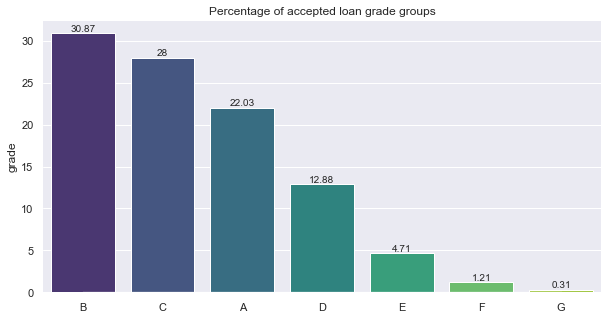

In [73]:
h.plot_barplot(percentage_grade, "grade", "Percentage of accepted loan grade groups")

So, one third of all accepted loans got grade "B", 28% - C and 22% A, only almost 13% - D and others are assigned very rare (it's understandable, as people with lower than D grade are mole likely to be problematic with paying the loan).

* Let's see what are the interest rates in every Loan grade.

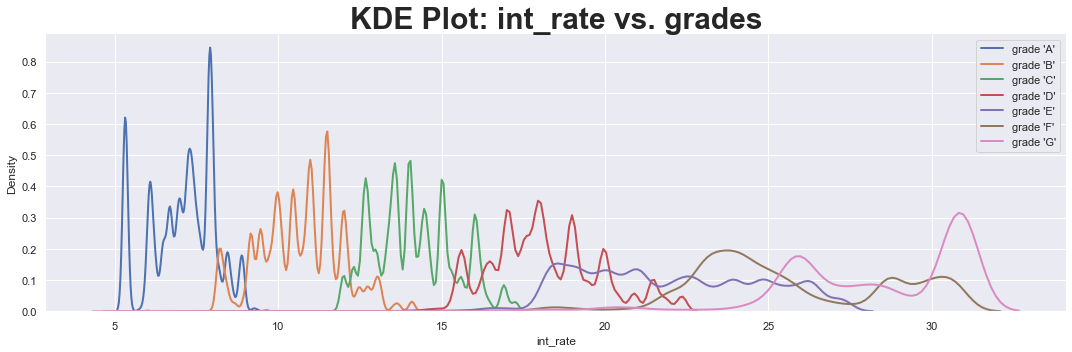

In [74]:
h.plot_grade_KDE(cleaned_accepted_df, "int_rate")

Very clear situation in this sector, grade and sub_grade determines the interest rate, given to the borrower. The better the grade, the lower possible interest rate aprox.:
* "A" - 5-9 %;
* "B" - 8-15 %;
* "C" - 13-17 %;
* "D" - 14-23 %;
* "E" - 15-27%;
* "F" - 17-33%
* "G" - 15-33%.

In [77]:
df_dictionary[df_dictionary["LoanStatNew"] == "avg_cur_bal"]

,LoanStatNew,Description
7,avg_cur_bal,Average current balance of all accounts


In [75]:
numerical_grade_df = cleaned_accepted_df[
    [
        "loan_amnt",
        "annual_inc",
        "dti",
        "fico_score",
        "last_fico_score",
        "avg_cur_bal",
        "grade",
    ]
].sort_values(by="grade")

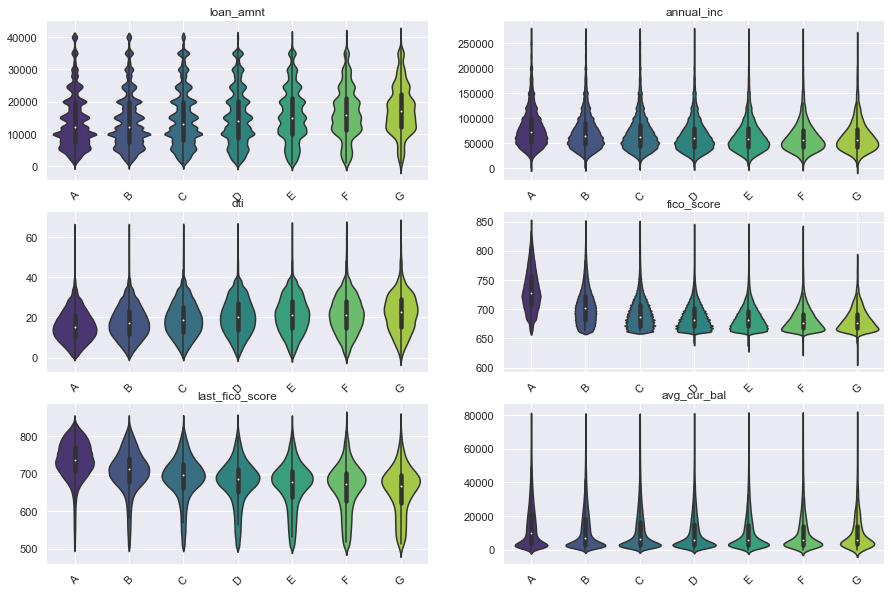

In [76]:
h.multiple_violinplots(numerical_grade_df, "grade")

Conclusions:
* quite clear negative linear relationship between grade and dti: as the grade group decreases (from A to G), the mean of loan amount and dti increases. For example mean dti in grade "A" is about ~15% and in grade "G" clearly over 20%. The mean of loan amount in grade "A" is closer to 10k$ and in grade "G" closer to 20k$;
* annual income, fico score and last fico score goes to the different direction: as the grade group decreases, the mean of annual income, fico and last fico score also decreases. Higher grade groups has higher mean od annual income and fico scores.
* mean of average currant balance of all accounts is higher in grade group "A", but in all remaining grade groups is actually, but I have doubts about this column, as it can be measured already after loan acceptance and I think I cannot use it in the modeling part.

In [78]:
categorical_grade = cleaned_accepted_df[
    ["term", "emp_length", "home_ownership", "purpose", "application_type", "grade"]
].sort_values(by="grade")

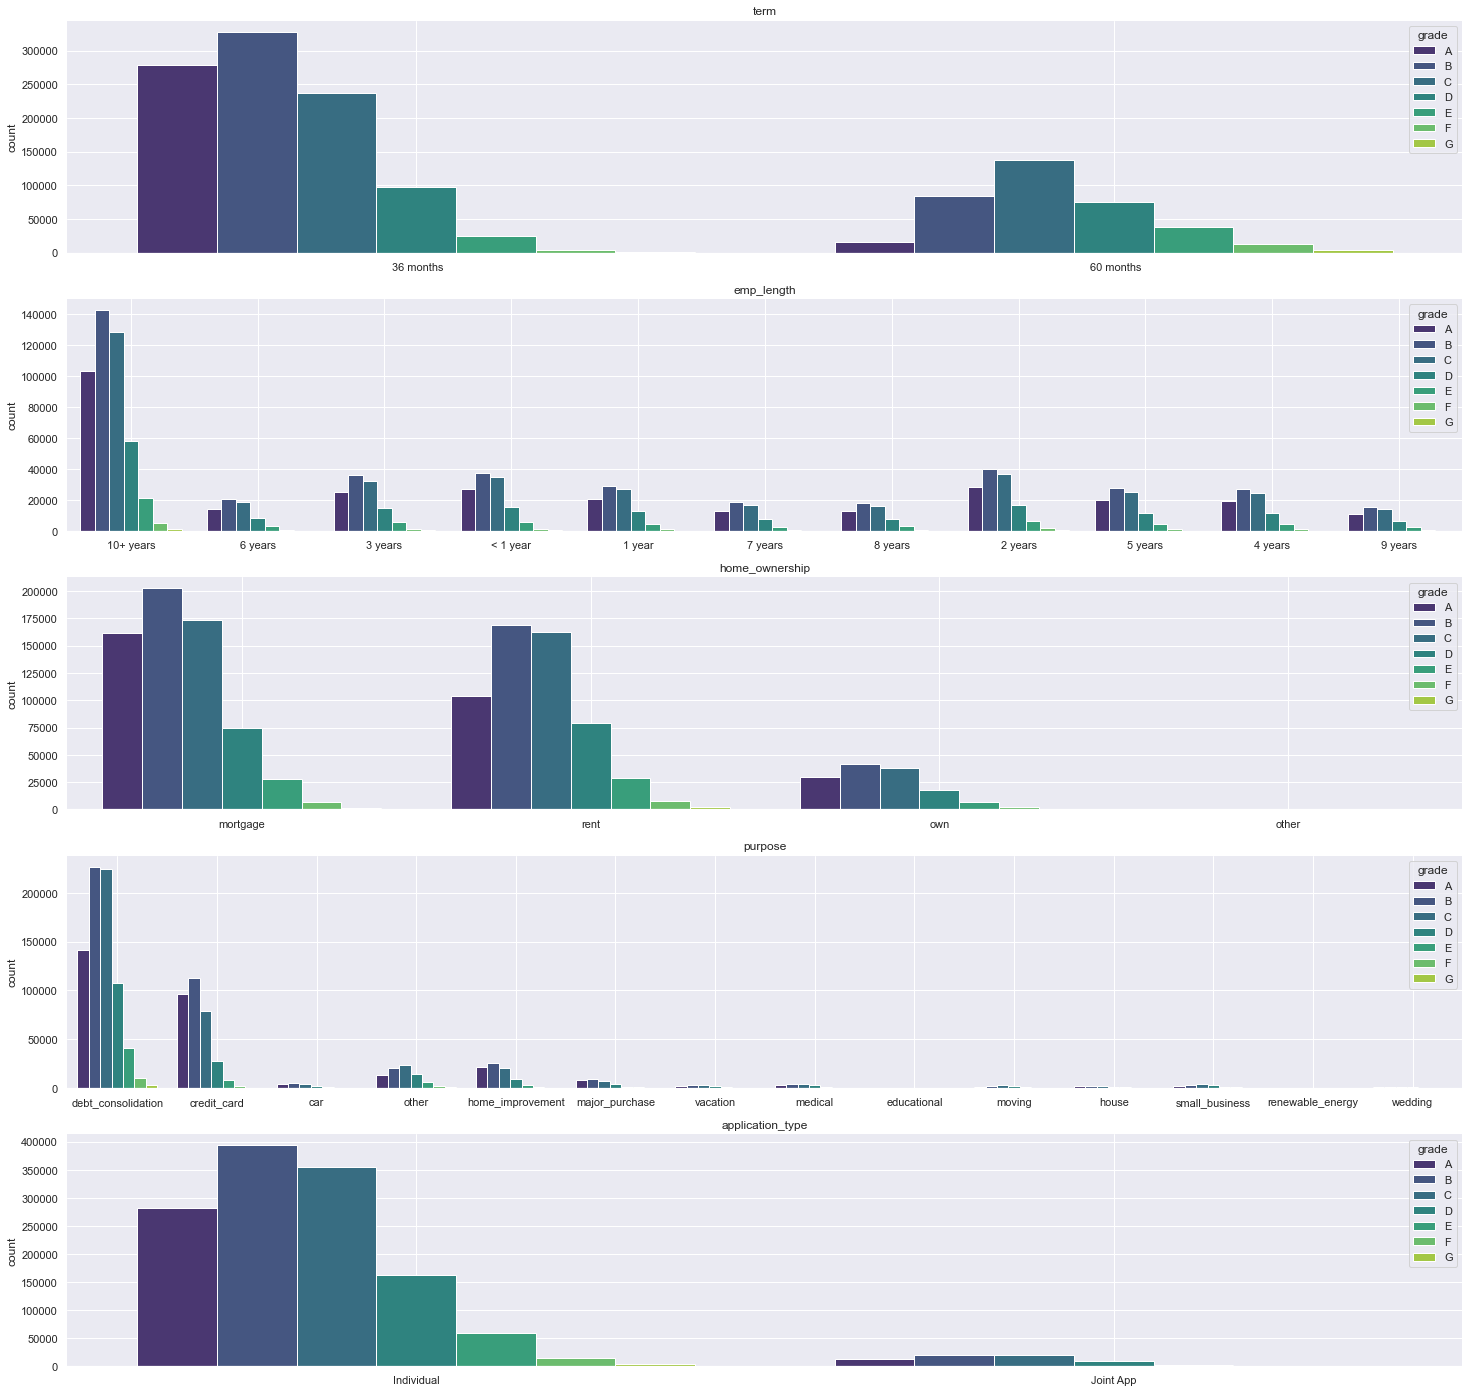

In [79]:
h.plot_categorical_countplots(categorical_grade, "grade")

Conclusion: 
all grade groups are available in all situations actually.

* Let's check the corelation coefficient:

In [29]:
cleaned_accepted_df["grade"].replace(
    ["A", "B", "C", "D", "E", "F", "G"], [0, 1, 2, 3, 4, 5, 6], inplace=True
)
correlation_matrix_grade = cleaned_accepted_df.corr()
correlation_matrix_grade = correlation_matrix_grade[["grade"]]
correlation_matrix_grade = correlation_matrix_grade[
    correlation_matrix_grade.index.str.contains("grade") == False
]
correlation_matrix_grade = correlation_matrix_grade.loc[
    (correlation_matrix_grade["grade"] >= 0.1)
    | (correlation_matrix_grade["grade"] <= -0.1)
].reset_index()

In [17]:
correlation_matrix_grade

,index,grade
0,int_rate,0.95
1,annual_inc,-0.13
2,dti,0.19
3,inq_last_6mths,0.17
4,inq_last_12m,0.15
5,acc_open_past_24mths,0.16
6,mo_sin_old_rev_tl_op,-0.12
7,mo_sin_rcnt_tl,-0.13
8,num_actv_rev_tl,0.10
9,fico_score,-0.44


### **3.2.3. Target: sub_grade**

In [82]:
list_sub_grades = cleaned_accepted_df["sub_grade"].unique().tolist()
len(sorted(list_sub_grades))

35

So in each grade we have sub grades from 1 to 5. Total number of 35 sub grade classes.

In [83]:
percentage_sub = pd.DataFrame(cleaned_accepted_df["sub_grade"].value_counts(normalize=True)*100)
percentage_sub["sub_grade"] = percentage_sub["sub_grade"].round(2)

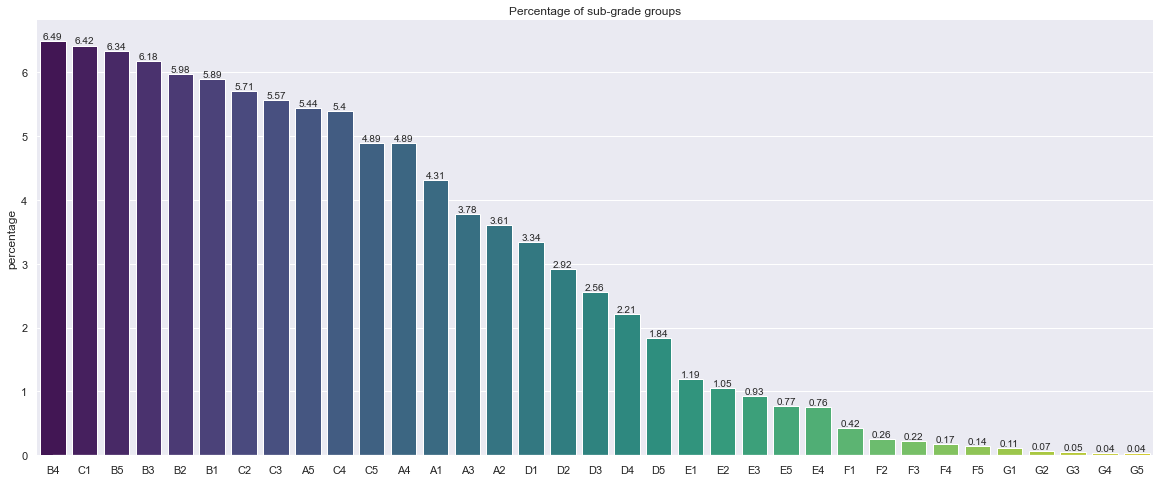

In [84]:
h.plot_barplot_subgrade(percentage_sub, "sub_grade", "Percentage of sub-grade groups")

* Mostly people are assigned with B1-5 and C1-3 sub grades. But that's becaus these grades "B" and "C" are given most often too.
* From grade "D" number of given subgrades lowers down very equally.

* Grade "B" subgroups vs. annual income, fico score and dti.

In [85]:
numerical_sub_grade_B = cleaned_accepted_df[cleaned_accepted_df["grade"] == 1][[
        "loan_amnt",
        "annual_inc",
        "dti",
        "fico_score",
        "last_fico_score",
        "avg_cur_bal",
        "sub_grade",
    ]
].sort_values(by="sub_grade")


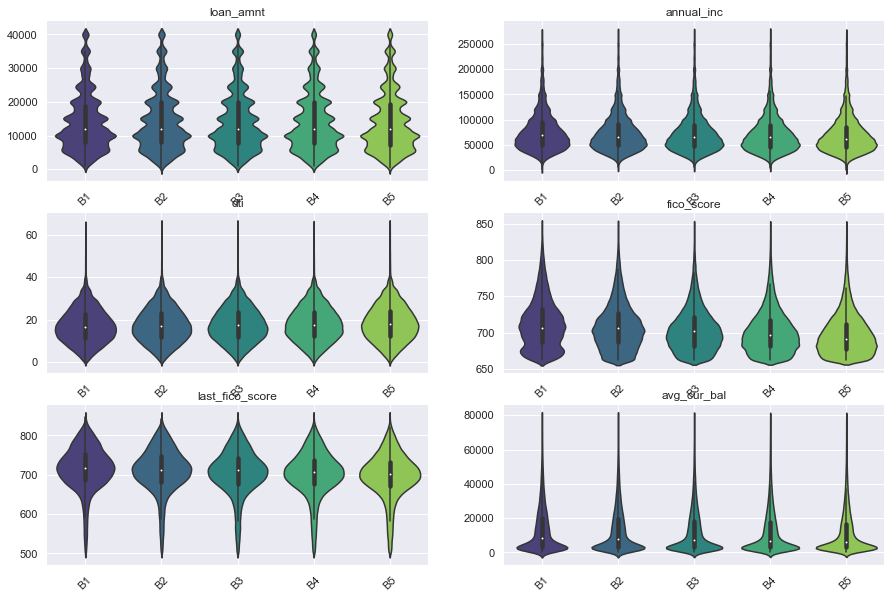

In [86]:
h.multiple_violinplots(numerical_sub_grade_B, "sub_grade")

Actually in all sub_grade groups all distributions looks quite similar, no clear patterns observed. The same situation with categorical features too. 

### **3.2.4. Target: interest rate (int_rate)**

In [30]:
cleaned_accepted_df.int_rate.describe()

count   1337923.00
mean         12.60
std           4.63
min           5.31
25%           9.17
50%          11.99
75%          15.05
max          30.99
Name: int_rate, dtype: float64

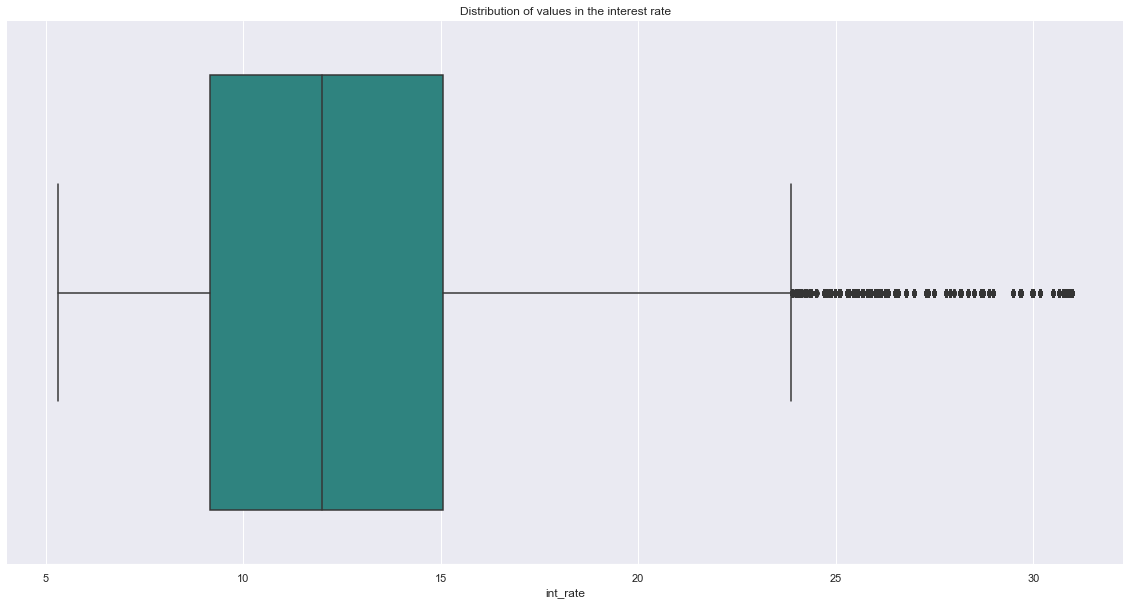

In [88]:
h.plot_boxplot(cleaned_accepted_df, "int_rate", None, "Distribution of values in the interest rate")

So we see, that higher interest rates - over 24 percent is actually quite rare, in the section, where we had explored grades, we sow, that they are very related, each grade kad it's upper and lower bounds of possible interest rates.
Let's see how interest rate varies in the: application_type, term and home_ownership features.

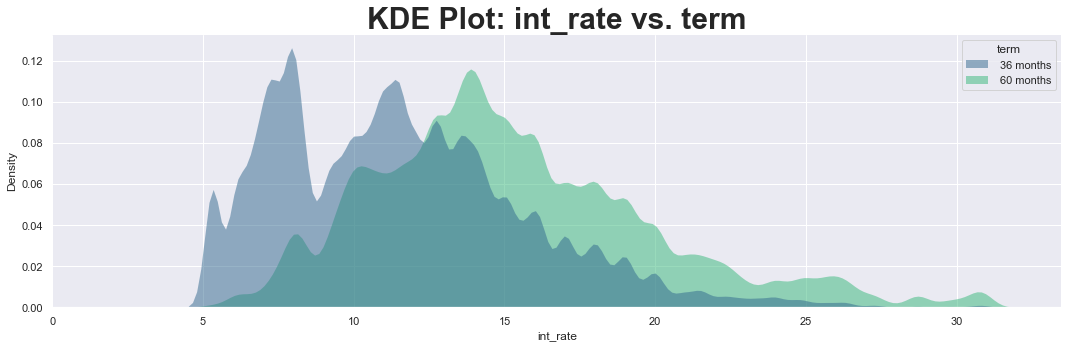

In [68]:
h.plot_kde(cleaned_accepted_df, "int_rate", "term")

So as it  could be predicted, higher term of the loan indicates higher interest rate.

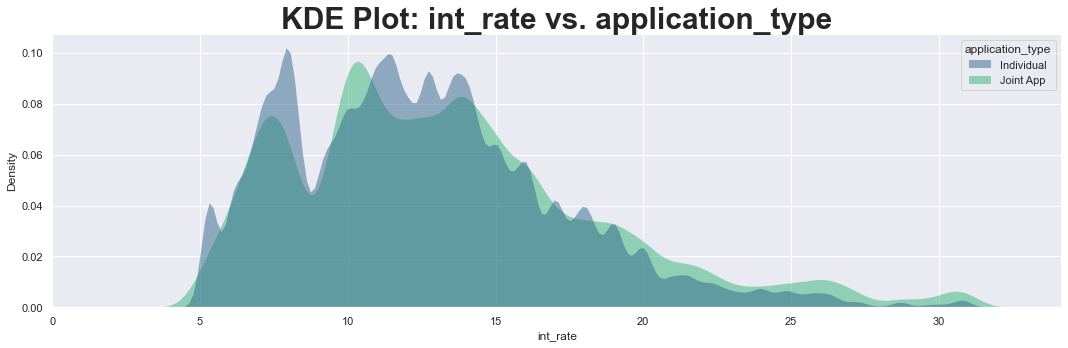

In [72]:
h.plot_kde(cleaned_accepted_df, "int_rate", "application_type")

In [18]:
correlation_matrix_int = cleaned_accepted_df.corr()
correlation_matrix_int = correlation_matrix_int[["int_rate"]]
correlation_matrix_int = correlation_matrix_int[
    correlation_matrix_int.index.str.contains("int_rate") == False
]
correlation_matrix_int = correlation_matrix_int.loc[
    (correlation_matrix_int["int_rate"] >= 0.1)
    | (correlation_matrix_int["int_rate"] <= -0.1)
].reset_index()

In [19]:
correlation_matrix_int

,index,int_rate
0,grade,0.95
1,annual_inc,-0.13
2,dti,0.19
3,inq_last_6mths,0.17
4,inq_last_12m,0.14
5,acc_open_past_24mths,0.16
6,mo_sin_old_rev_tl_op,-0.13
7,mo_sin_rcnt_tl,-0.12
8,mort_acc,-0.10
9,num_actv_rev_tl,0.10


So we see that mostly it correlates with annual_income, dti, fico score, last fico score and of course grade and sub_grade.

### 3.2.5. Some additional cleaning and saving the working data set's for modeling

* Accepted + rejected loan data set final cleaning and saving for modeling.

In [92]:
final_loans = final_loans.replace(
    {
        "emp_length": {
            "< 1 year": 0,
            "1 year": 1,
            "2 years": 2,
            "3 years": 3,
            "4 years": 4,
            "5 years": 5,
            "6 years": 6,
            "7 years": 7,
            "8 years": 8,
            "9 years": 9,
            "10+ years": 10,
        }
    }
)

In [93]:
final_loans.head()

,loan_amnt,purpose,fico_score,dti,addr_state,emp_length,year,month,status
0,24700.00,small_business,717.00,16.06,SD,10,2015,12,1
1,20000.00,home_improvement,697.00,10.78,IL,10,2015,12,1
2,35000.00,debt_consolidation,787.00,17.06,NJ,10,2015,12,1
3,10400.00,major_purchase,697.00,25.37,PA,3,2015,12,1
4,8000.00,credit_card,702.00,34.80,RI,10,2015,12,1


* Also I decided to take only data from 2013, as we have data from 2007 (including economical crisis), which, in my opinion is too old.

In [126]:
final_loans = final_loans[final_loans["year"] >= 2013]

In [128]:
#final_loans.to_csv("all_loans_df.csv", index=False)

* Accepted loans df final cleaning and saving for modeling.

In [31]:
# Dropping additional columns and Nan values. First of all most of the columns had data, which, in my opinion
# could be from period when loan was already accepted and even funded. Like avg of credit cards, sums in cards and so on.
# I decided not to use them, as it could cause data from future leakage.

cleaned_accepted_df = cleaned_accepted_df.pipe(
    h.drop_columns,
    [
        "funded_amnt",
        "funded_amnt_inv",
        "mo_sin_old_rev_tl_op",
        "mo_sin_rcnt_rev_tl_op",
        "mo_sin_rcnt_tl",
        "mths_since_recent_bc",
        "num_actv_bc_tl",
        "num_actv_rev_tl",
        "num_bc_sats",
        "num_bc_tl",
        "num_il_tl",
        "num_op_rev_tl",
        "num_rev_accts",
        "num_sats",
        "hardship_flag",
    ],
).pipe(h.drop_all_nan_rows)

In [32]:
# Cleaning earliest credit line.
cleaned_accepted_df["earliest_cr_line"]
cleaned_accepted_df["earliest_cr_line_year"] = cleaned_accepted_df["earliest_cr_line"].copy()
cleaned_accepted_df["earliest_cr_line_year"] = cleaned_accepted_df["earliest_cr_line_year"].str.split("-")
cleaned_accepted_df["earliest_cr_line_year"] = [item[1] for item in cleaned_accepted_df["earliest_cr_line_year"]]
cleaned_accepted_df["earliest_cr_line_year"] = pd.to_numeric(cleaned_accepted_df["earliest_cr_line_year"])
cleaned_accepted_df = (cleaned_accepted_df.pipe(h.drop_columns, ["earliest_cr_line"]))

In [33]:
# Cleaning emp_length
cleaned_accepted_df = cleaned_accepted_df.replace(
    {
        "emp_length": {
            "< 1 year": 0,
            "1 year": 1,
            "2 years": 2,
            "3 years": 3,
            "4 years": 4,
            "5 years": 5,
            "6 years": 6,
            "7 years": 7,
            "8 years": 8,
            "9 years": 9,
            "10+ years": 10,
        }
    }
)

In [34]:
cleaned_accepted_df = cleaned_accepted_df[cleaned_accepted_df["year"] >= 2013]

In [35]:
# cleaned_accepted_df.to_csv("accepted_loans.csv", index=False)

# Conclusions

**General information**:
* In the period from 2007 to 2018 Lending Club has accepted over 2 million and rejected over 27 million loan applications. The ratio of accepted and rejected in total is 1 (accepted) to 12 (rejected).
* Mostly the funded sum was equal to the asked sum. 
* Mostly people applied for individual loans, even though joint applications have a higher possibility of approval and higher funded loan amount.

**Rejected vs. accepted loans**:

**1. Rejected application:** 
* people had asked loan amounts, that exceeded personal loan upper bound in Lending Club (40k$); but also more often smaller amounts were asked: starting from 150 to 5000$; more often people asked rounded sums; the mean is over 12k$;
* purpose: mostly debt_consolidation, car (possibly auto loan refinancing, financing for the new car and etc.) and other reasons; there is a large number of "other" reasons for the loan (more than in the accepted loan group), which possibly aren't so important or even cannot be financed.
* fico score: std is actually double when compared with accepted, so the variance of Fico score in the rejected loans group is definitely higher.
* debt to income ratio: to get a loan with Debt to income ratio exceeding 40 percent is impossible; there are applications with dti of 0, which might also be suspicious; std is almost three times higher than in the accepted loan group, values obviously are more spread away.
* state: highest percentage of rejection: Alabama, Mississippi, Iowa.
* employment length: wast majority of rejected applicant did not have even one year of employment (good predictor).People with less than 1 year of employment experience has lower fico range (mean and absolute minimum) and higher mean of dti (also the upper outliers - 100 percent ratio of dti). So there is a relationship between length of employment and calculated fico score and dti.
* year: the number of rejected loans by year differs quite a lot. It may be due to the fact, that I deleted a lot  of data and some years must have had a lot of NaN values (like the year of 2015). But all in all we can see the increase in the number of accepted and rejected loans year by year.
* month: the number of rejected loans by months varies very much - starting from July it starts to increase (probably the number of applies increase too) and reaches the peak in December (that's probably related to the main holidays of the year).

**2. Accepted loans:**
* were asked sums from 500$ to 40 000$  - all in the range of personal loans of Lending Club; more often not rounded sums were asked, seems that people better knew how much and for what certain purpose they are asking the loan; mostly were asked sums from 5000 to 25 000 $; mean of the asked loan amounts is higher than in the rejected loans group and reaches over 14 thousand, the difference is statistically significant.
* purpose: mostly debt_consolidation, credit_card, home_improvement and other reason;
* fico score: to get a loan in Lending Club you need to have Fico score from aprox. 660 and above. The mean of the Fico score in the accepted loans data set is obviously higher than in the rejected and it is statistically significant. Standard deviation of Fico score in rejected loans data set is actually double, compared to the Fico score std in the accepted loan group. So the variance of Fico score in the rejected loans group is definitely higher.
* debt to income ratio: mostly between 15-25 percent. 
* the highest percent of accepted loans are not in the largest states, but in Minnesota, Colorado and North Dakota;the lowest percentage of acceptance is in: Alabama, Mississippi, Iowa.
* employment length: mostly for more than 10 years, but the Lending Club approves loans for people with 2 and even less than 1 year of employment quite well too.
* year: the number of the accepted loans is increasing steadily year by year. 
* month: the number of accepted loans is very stable during every month of the year, there is no major increases or decreases. 

**Grades, sub_grades and int_rate**:
* So, one third of all accepted loans got grade "B", 28% - "C" and 22% "A", only almost 13% - "D" and others are assigned very rare (it's understandable, as people with lower than D grade are more likely to be problematic with paying the loan). 
* There is a quite clear int rate by grade (grade, subgrade and int rates are totally related): "A" - 5-9 %; "B" - 8-15 %; "C" - 13-17 %; "D" - 14-23 %; "E" - 15-27%; "F" - 17-33%, "G" - 15-33%.
* Quite clear negative linear relationship between grade, loan amount and dti: as the grade group decreases (from "A" to "G"), the mean of loan amount and dti increases.
* Annual income, fico score and last fico score goes to the different direction: as the grade group decreases, the mean of annual income, fico and last fico score also decreases. Higher grade groups has higher mean od annual income and fico scores.
* Mean of average current balance of all accounts is higher in grade group "A", but in all other remaining grade groups is actually very equal, but I have doubts about this column, as it can be measured already after loan acceptance and I think I cannot use it in the modeling part.
* Mostly people are assigned with B1-5 and C1-3 sub grades. But that's because these grades "B" and "C" are given most often too.
* From grade "D" number of given subgrades lowers down very equally.
* Interest rate varies from 5 to 35 percent and is very related with the assigned grade and subgrade. 